## Modelling

In [36]:
# Here first we will create a copy and separate the target variable as we do not want to do the same transformation

In [37]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

### Data Pipeline

In [38]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [39]:
# Now, we will write custom functions/transformers to add extra attributes we discussed earlier in the dataset.
# Writing custom transformers helps in automatic hyper parameter tuning. The code below has one hyper parameter,
# add_bedrooms_per_room, set to True by default. 
# Which will help us to determine if adding this attribute will help the model or not.

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [41]:
# ML models don’t perform well when input features are in different scales. 
# So, we will standardize the all the numeric features except for target variable.

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

### Transforming Categorical Variables

In [43]:
from sklearn.compose import ColumnTransformer

housing_num = housing.drop("ocean_proximity", axis=1)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])


In [44]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Training a Machine Learning Model

###  Linear Regression

In [82]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [83]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [204000. 326560. 203680.  58688. 194432.]


In [84]:
### Compare against actual values

print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [85]:
# In first instance, our model is off by around $76,000. Let’s measure RMSE of the regression model.

In [86]:
from sklearn.metrics import mean_squared_error  
housing_predictions = lin_reg.predict(housing_prepared) 
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse) 
lin_rmse

68380.12273997058

In [87]:
lr = r2_score(housing_labels, housing_predictions)
lr

0.6507015134985605

In [50]:
# The RMSE tells us that model has typical prediction error of $68,380 which is pretty big. 
# We could try to add more feature or try more complex model to make model more accurate. 

### Decision Trees

In [51]:
### Using DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [52]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [53]:
# Cross validation

In [54]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [55]:
### Let's look at the scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [68819.75267777 68342.33520328 70622.36427958 69811.72234331
 71401.76032248 74089.44774089 71847.55873533 70671.08850854
 76171.85388855 71370.97731792]
Mean: 71314.88610176415
Standard deviation: 2231.548220587874


In [56]:
## Using cross validation on linear regression

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66882.23734945 66610.40636358 70582.1507026  74181.46627292
 67685.10769559 71106.2190578  64786.29838954 67710.02254842
 71086.26337674 67690.41325331]
Mean: 68832.05850099438
Standard deviation: 2663.0013594992347


In [57]:
#Now, we can see that linear regression was even better than decision tree which has mean error of $71,407 
# with standard deviation of +- $2,439 compare to $68,628 RMSE of linear regression. 

### Random Forest

In [89]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=5, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(n_estimators=5, random_state=42)

In [90]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse) 
forest_rmse

25723.253718042473

##### Model prediction error is just $18,603 on training sets. 

In [91]:
forest_acc = r2_score(housing_labels, housing_predictions)
forest_acc

0.9505702112311869

In [61]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [54617.99576965 55343.72727579 56532.63349231 53792.60326966
 57098.80385372]
Mean: 55477.15273222593
Standard deviation: 1211.4001754465362


##### so far one of the best model with the error rate of $50,182

# Fine tuning the model

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [64]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [65]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [66]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64460.5181068357 {'max_features': 2, 'n_estimators': 3}
55825.50936235517 {'max_features': 2, 'n_estimators': 10}
53294.15665544071 {'max_features': 2, 'n_estimators': 30}
61207.54541025911 {'max_features': 4, 'n_estimators': 3}
53871.89816769728 {'max_features': 4, 'n_estimators': 10}
51382.01993484741 {'max_features': 4, 'n_estimators': 30}
59865.907956066316 {'max_features': 6, 'n_estimators': 3}
53086.267981017125 {'max_features': 6, 'n_estimators': 10}
50689.16973314965 {'max_features': 6, 'n_estimators': 30}
59339.54458651603 {'max_features': 8, 'n_estimators': 3}
53134.185423174655 {'max_features': 8, 'n_estimators': 10}
50990.177210950395 {'max_features': 8, 'n_estimators': 30}
62166.83853815223 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54448.313958726496 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60796.502531583166 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52858.41577446194 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [67]:
# Randomized hyper parameter search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49951.08241777783 {'max_features': 7, 'n_estimators': 180}
51785.10430961075 {'max_features': 5, 'n_estimators': 15}
51436.804480512925 {'max_features': 3, 'n_estimators': 72}
51176.69272286088 {'max_features': 5, 'n_estimators': 21}
50057.05679705256 {'max_features': 7, 'n_estimators': 122}
51408.692790428795 {'max_features': 3, 'n_estimators': 75}
51275.320292567536 {'max_features': 3, 'n_estimators': 88}
50302.54673345825 {'max_features': 5, 'n_estimators': 100}
50980.83517478715 {'max_features': 3, 'n_estimators': 150}
65067.49999919616 {'max_features': 5, 'n_estimators': 2}


##### looking the importance of features in the random forest model.

In [68]:
# Feature Importance
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.24342861360691884, 'median_income'),
 (0.16206246965941018, 'income_cat'),
 (0.10766821432031576, 'pop_per_hhold'),
 (0.10695853955894917, 'INLAND'),
 (0.06724573739361057, 'longitude'),
 (0.059712421439829265, 'bedrooms_per_room'),
 (0.05873333021179715, 'latitude'),
 (0.05365840409387858, 'rooms_per_hhold'),
 (0.0463026542521523, 'housing_median_age'),
 (0.019168848202413925, 'population'),
 (0.018886189714881478, 'total_bedrooms'),
 (0.018223963248666288, 'households'),
 (0.018113319948291556, 'total_rooms'),
 (0.012014170855160277, '<1H OCEAN'),
 (0.0053494834133635295, 'NEAR OCEAN'),
 (0.00241345108667141, 'NEAR BAY'),
 (6.018899368976134e-05, 'ISLAND')]

In [69]:
# This step allows us the opportunity to understand which feature are most important and which are of low importance

## Evaluate the Model on the Test Set

In [70]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49288.788177123024

In [71]:
# Computing 95% confidence interval
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([47299.86945423, 51200.50419236])

##### This tells us that prediction error can fluctuate anywhere between $45,685 to $49,691. 
##### Around $4,000 gap in confidence interval is something we can live with. So, this is our final model. 

In [78]:
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
r2_score(y_test,final_predictions)

0.8135780153140701

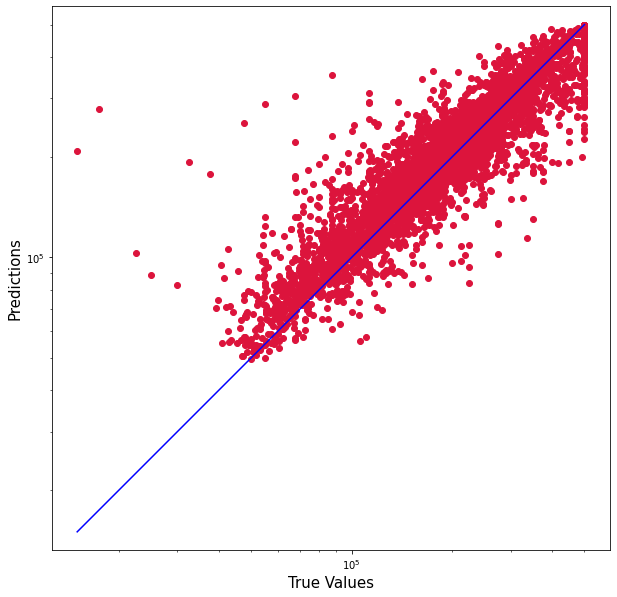

In [79]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, final_predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(final_predictions), max(y_test))
p2 = min(min(final_predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()